In [306]:
import numpy as np
import matplotlib.pyplot as plt

# Variable Hyperparameters
num_qubits_list = [4, 8]
r_list = [0.0, 0.5, 1.0]
var_ansatz_list = ["QCNN_not_shared", "QCNN_shared", "SEL"]
var_anstaz_label_list = ["QCNN\n (not shared)", "QCNN\n(shared)", "SEL"]
num_layers_list = [1, 3, 5, 7, 9]

def load_data(PATH):
    return (
        np.load(PATH + 'generalization_gap.npy'),
        np.load(PATH + 'test_acc.npy'),
        np.load(PATH + 'mu_marg_Q1.npy'),
        np.load(PATH + 'mu_marg_Q2.npy'),
        np.load(PATH + 'mu_marg_mean.npy'),
        np.load(PATH + 'mu_param.npy'),
        np.load(PATH + 'mu_param_eff10.npy'),
        np.load(PATH + 'mu_param_eff100.npy')
    )

def get_data_(num_qubits, r, var_ansatz, num_layers, exp_range=5, exp_index=None):
    data = []
    
    if exp_index is not None:  # For a single experiment
        exp_range = 1
        exp_list = [exp_index]
    else:  # For multiple experiments
        exp_list = range(1, exp_range + 1)
    
    for exp in exp_list:
        PATH = f'../../results/{num_classes}C/{r}R/{num_qubits}Q/{var_ansatz}/{num_layers}L_{max_steps}MS_Full BatchBS_{learning_rate}LR_{convergence_interval}conv/20S/{exp}E/'
        data.append(load_data(PATH))

    data = np.array(data)  # Shape: (exp_range, 8, ...)
    
    if exp_index is None:  # For multiple experiments, return mean and std
        means = np.mean(data, axis=0)
        stds = np.std(data, axis=0)
        return np.stack((means, stds), axis=1)  # Shape: (8, 2, ...)
    else:  # For single experiment, return the data directly
        return data[0]

# Define the reciprocal transformation separately
def reciprocal_transform(x):
    return 1 / x

def apply_transformation(data, transforms):
    transformed_data = []
    for datum, transform in zip(data, transforms):
        transformed_data.append(transform(datum))
    return transformed_data

def append_data(lists, data, transforms):
    for lst, (mean, std), transform in zip(lists, data, transforms):
        transformed_mean = transform(mean)
        
        # Determine how to transform std dev based on the transformation applied to the mean
        if transform == np.sqrt:
            transformed_std = std / (2 * np.sqrt(mean))
        elif transform == reciprocal_transform:
            transformed_std = std / (mean**2)
        else:
            transformed_std = std  # No transformation applied to std dev for identity and linear transforms
        
        lst[0].append(transformed_mean)
        lst[1].append(transformed_std)

def get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_range=20, exp_index=None):
    g_lists = ([], [])
    test_acc_lists = ([], [])
    mu_marg_Q1_lists = ([], [])
    mu_marg_Q2_lists = ([], [])
    mu_marg_mean_lists = ([], [])
    mu_param_lists = ([], [])
    mu_param_eff10_lists = ([], [])
    mu_param_eff100_lists = ([], [])
    
    data_lists = [
        g_lists, test_acc_lists, mu_marg_Q1_lists, mu_marg_Q2_lists,
        mu_marg_mean_lists, mu_param_lists, mu_param_eff10_lists, mu_param_eff100_lists
    ]
    
    transforms = [
        lambda x: x, lambda x: x, reciprocal_transform, reciprocal_transform,
        reciprocal_transform, np.sqrt, np.sqrt, np.sqrt
    ]

    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    
    for param_value in param_map[x_axis]:
        if x_axis == "num_layers":
            num_layers = param_value
        elif x_axis == "r":
            r = param_value
        elif x_axis == "var_ansatz":
            var_ansatz = param_value

        data = get_data_(num_qubits, r, var_ansatz, num_layers, exp_range, exp_index)
        
        if exp_index is None:  # For multiple experiments
            append_data(data_lists, data, transforms)
        else:  # For single experiment, transform data directly
            transformed_data = apply_transformation(data, transforms)
            for lst, datum in zip(data_lists, transformed_data):
                lst[0].append(datum)

    # Convert lists to numpy arrays
    g_array = np.array(g_lists)
    test_acc_array = np.array(test_acc_lists)
    mu_marg_Q1_array = np.array(mu_marg_Q1_lists)
    mu_marg_Q2_array = np.array(mu_marg_Q2_lists)
    mu_marg_mean_array = np.array(mu_marg_mean_lists)
    mu_param_array = np.array(mu_param_lists)
    mu_param_eff10_array = np.array(mu_param_eff10_lists)
    mu_param_eff100_array = np.array(mu_param_eff100_lists)
    
    return np.array([g_array, test_acc_array, mu_marg_Q1_array, mu_marg_Q2_array, 
                     mu_marg_mean_array, mu_param_array, mu_param_eff10_array, 
                     mu_param_eff100_array])

# Define a dictionary to map y-axis variable names to their corresponding data in the get_data function
data_mapping = {
    "generalization gap": 0,
    "test accuracy": 1,
    "margin (Q1)": 2,
    "margin (Q2)": 3,
    "margin (mean)": 4,
    "params": 5,
    "effective params (0.1)": 6,
    "effective params (0.01)": 7
}

In [307]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def getplots_single(x_axis, y_axis1, y_axis2, y_axis3, num_qubits, var_ansatz, r, num_layers, exp_index=0):
    # Mapping for x-axis labels
    x_axis_label_map = {
        "num_layers": "Number of Layers",
        "r": "Percentage of Randomized Labels",
        "var_ansatz": "Variational Ansatz"
    }
    
    # Mapping for x-ticks
    x_ticks_map = {
        "QCNN_not_shared": "QCNN",
        "QCNN_shared": "QCNN (param shared)"
    }

    fig, ax_left = plt.subplots(figsize=(7, 6))
    plt.rcParams.update({'font.size': 14}) 

    # Create the first y-axis on the right
    ax_right1 = ax_left.twinx()

    # Create the second y-axis on the right
    ax_right2 = ax_left.twinx()
    ax_right2.spines['right'].set_position(('outward', 50))  # Offset the second y-axis

    # Get data for the single experiment
    data = get_data(x_axis, num_qubits, var_ansatz, r, num_layers, exp_range=1, exp_index=exp_index)

    # Assuming num_layers_list corresponds to the selected x_axis data range
    param_map = {
        "num_layers": num_layers_list,
        "r": r_list,
        "var_ansatz": var_ansatz_list
    }
    x_data = param_map[x_axis]

    # Map x-ticks if necessary
    x_data = [x_ticks_map.get(label, label) for label in x_data]

    # Extract the relevant data for the single experiment using the mapping
    y1_list = data[data_mapping[y_axis1]][0]
    y2_list = data[data_mapping[y_axis2]][0]
    y3_list = data[data_mapping[y_axis3]][0]

    # Plotting on the left y-axis with solid line
    line1, = ax_left.plot(x_data, y1_list, label=y_axis1, marker='x', markersize=7, color='purple', linestyle='-')
    if x_axis == "num_layers":
        ax_left.set_ylabel(y_axis1, color='purple')
        #ax_left.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure y-ticks are integers

    # Plotting on the first right y-axis with dashed line
    line2, = ax_right1.plot(x_data, y2_list, label=y_axis2, marker='o', markersize=7, color='red', linestyle='--')
    if x_axis == "var_ansatz":
        ax_right1.set_ylabel(y_axis2, color='red')
        #ax_right1.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure y-ticks are integers

    # Plotting on the second right y-axis with dotted line
    line3, = ax_right2.plot(x_data, y3_list, label=y_axis3, marker='^', markersize=7, color='green', linestyle=':')
    if x_axis == "var_ansatz":
        ax_right2.set_ylabel(y_axis3, color='green')
        #ax_right2.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure y-ticks are integers

    # Combine legends from all axes into one
    lines = [line1, line2, line3]
    labels = [line.get_label() for line in lines]
    if x_axis == "num_layers":
        ax_left.legend(lines, labels, loc='lower center')

    # Set x-axis label
    ax_left.set_xlabel(x_axis_label_map.get(x_axis, x_axis))
    ax_left.set_xticks(x_data)
    
    # Adjust layout to ensure no cropping
    plt.tight_layout()

    # Save figure with bounding box that includes all elements
    plt.savefig(f'comparison_{x_axis}.pdf', bbox_inches='tight')
    plt.show()


In [308]:
y_axis1 = "margin (Q2)"
y_axis2 = "effective params (0.01)"
num_qubits = 8
var_ansatz = "QCNN_not_shared"
r = 0.0
num_layers = 7
exp = 1

/tmp/ipykernel_30375/4146175167.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  g_array = np.array(g_lists)
/tmp/ipykernel_30375/4146175167.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_acc_array = np.array(test_acc_lists)
/tmp/ipykernel_30375/4146175167.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mu_mar

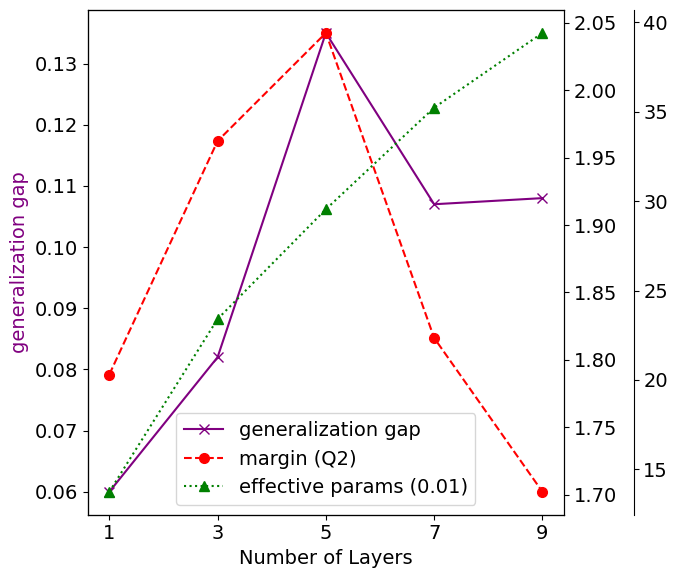

In [309]:
#getplots_average("num_layers", "generalization gap", "margin (Q1)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 1)
getplots_single("num_layers", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)

/tmp/ipykernel_30375/4146175167.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 / x
/tmp/ipykernel_30375/4146175167.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  g_array = np.array(g_lists)
/tmp/ipykernel_30375/4146175167.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_acc_array = np.array(test_acc_lists)
/tmp/ipykernel_30375/4146175167.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or 

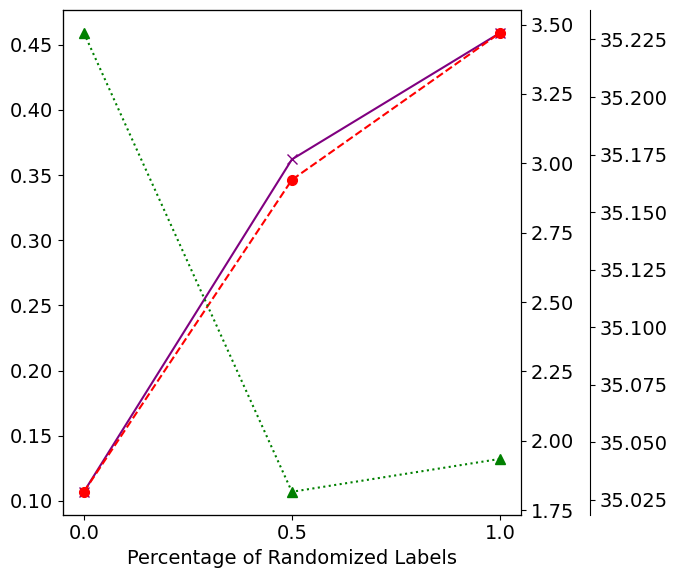

In [310]:
#getplots_average("r", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("r", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)

/tmp/ipykernel_30375/4146175167.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  g_array = np.array(g_lists)
/tmp/ipykernel_30375/4146175167.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_acc_array = np.array(test_acc_lists)
/tmp/ipykernel_30375/4146175167.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mu_mar

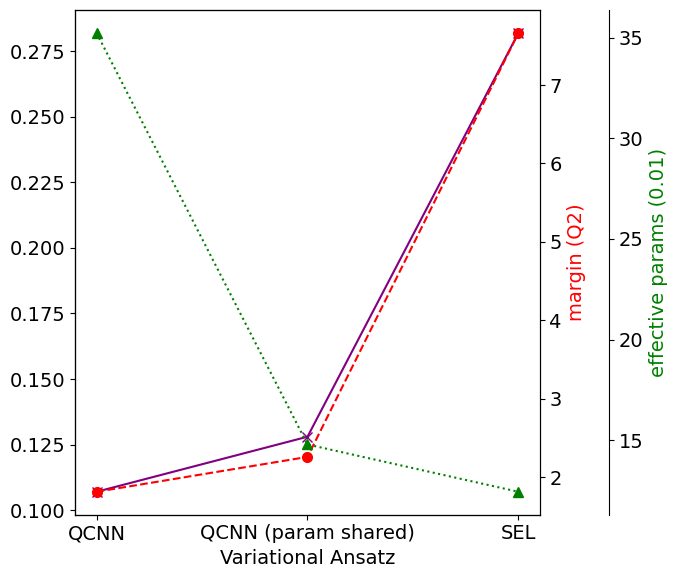

In [311]:
#getplots_average("var_ansatz", "generalization gap", "margin (mean)", "effective params (0.01)", 8, "QCNN_not_shared", 0.0, 1, 20)
getplots_single("var_ansatz", "generalization gap", y_axis1, y_axis2, num_qubits, var_ansatz, r, num_layers, exp)